In [1]:
import os 
import time

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

#np.random.seed(3)
#torch.manual_seed(3)

# Simulating Geometric Brownian Motion

We use the *Euler method* outlined in §6.3 of Shreve, 2004. Beginning at $S(0) = x$ and given some small $dt$, let

\begin{equation}
S(t + dt) = x + r S(t) dt + \sigma S(t) \sqrt{dt} \epsilon_1, 
\end{equation}

where $\epsilon_1$ ~ N(0, 1). Then

\begin{equation}
S(t + 2dt) = S(t + dt) + r S(t + dt) dt + \sigma S(t + dt) \sqrt{dt} \epsilon_2
\end{equation}
where $\epsilon_1$ ~ N(0, 1), and so on. We implement this exact algorithm below.

In [2]:
class GBM:
  def __init__(self, S0=100, r=0, sigma=0.01, T=21/365, dt=1/365):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T = T
    self.dt = dt
    #np.random.seed(3) # GBM paths will be the same every time

  # T=21 is chosen to correspond to a 21 trading days in a month
  # dt affects how close we want our approximation to be to a true Brownian motion. 
  # Lowering dt significantly increases computation time.
  # Setting dt=1 makes computation fast and interpretation simple.
  def generate_path(self):
    f = lambda x: x + self.r * x * self.dt + self.sigma * x * np.sqrt(self.dt) * np.random.normal()
    path = [self.S0]
    for i in range(1, int(self.T/self.dt)):
      path.append(f(path[i-1]))
    return path

  def generate_paths(self, n):
    paths = []
    for i in range(n):
      paths.append(self.generate_path())
    return paths

  def plot_paths(self, paths, n=20):
    plt.figure(figsize = (20, 5)) 
    plt.title(f'{len(paths)} Geometric Brownian Motion sample paths')
    plt.ylabel('Price')
    plt.xlabel('Ticks')
    for i in paths:
      plt.plot(i)

We have chosen sigma=0.1 below since it produces a variation in stock price which seems natural over the course of a trading month.

In [3]:
gbm = GBM(S0 = 100, r=0, sigma=0.1)
sample_paths = GBM.generate_paths(gbm, 100)

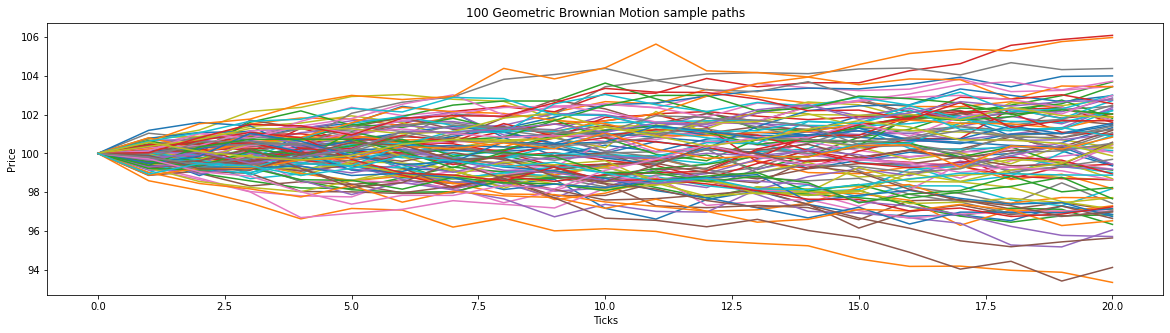

In [4]:
GBM.plot_paths(gbm, sample_paths)

We note that one quirk of the *Euler method* is that we cannot set $S = 0$, and that if $S > 0$, then $S(t) > 0$ for all $t \in \{0, \dots, T\}$.

# Fully-connected feedforward network

How do we structure the network? Suppose there is a market maker who has sold an Asian call option on a stock, and wishes to hedge their risk. The result of Chapter 1 of the dissertation is that this market marker should hold
\begin{equation}
\Delta(t) = f_s(t, S(t), Y(t))
\end{equation}
units of the stock in their hedging portfolio at each $t \in \{0, T\}$. I.e. in theory, we only need to know $t$, $S(t)$ (the stock price) and, $Y(t)$ (the integrated stock price) to determine $\Delta(t)$. This suggests that the following network structure:
* three cells in the input layer (one for $t$, one for $S(t)$ and the other for $Y(t)$)
* one cell in the output layer (for $\Delta(t)$)

Assuming the network's weights are such that it has been trained to approximate $f_s$, if we input $S(t)$ and $Y(t)$ **at any** $t \in \{0, T\}$, then the network should output $\Delta(t)$.

However, we do not have true values of $\Delta(t)$ to compare the model's output with. We would also like to compare the performance of this feedforward network with the performance of an RNN which we have trained to approximate $\Delta$. 

We can satisfy both of these concerns as follows. For each sample path $S$, we can compute the vector $Y$ and we know the vector $\boldsymbol{t}$. We split this sample path into $T$ training examples. We feed each of these training examples into our feedforward neural network, and obtain $T$ values of $\Delta(t)$, each at a different time $t \in \{0, \dots, T\}$. We do this for every sample path $S_k$ in our minibatch of sample paths $\{S_1, \dots, S_B\}$. Then, we compute the loss 
\begin{equation}
\mathbb{\tilde{E}} [(p_0 + (\delta \cdot S)_{T} - Z)^2] = 
\frac{1}{B} \sum_{k=1}^{B} [(p_0 + (\delta_k \cdot S_k)_{T} - Z_k)^2],
\end{equation}
where B is the minibatch size. The implementation is actually more complex than for the RNN.

In [5]:
from torch import nn 

def getMLP(hidden_size=10, dropout_prob=0):
    MLP = nn.Sequential(
        nn.Linear(3, hidden_size), 
        nn.ReLU(), 
        #nn.Dropout(p=dropout_prob),
        nn.Linear(hidden_size, 1))
    return MLP

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, std=0.01)

# Loss function

We use the exact same loss function as for the RNN. The implementation may be slightly different, to preserve gradients properly.

In [6]:
# We use this for training
def training_loss(deltas, paths, payoffs):
    # Note, all operations use matrix algebra to preserve gradients
    asset_price_differences = torch.squeeze(torch.diff(paths, n=1, dim=1)).float() # does not have gradient, as expected
    
    hedging_PL = torch.matmul(deltas, asset_price_differences.T) 
    hedging_PL = torch.matmul(torch.eye(batch_size), hedging_PL) # Throw away (delta_i \cdot S_j) if i ≠ j) by multiplying with identity
    hedging_PL = torch.sum(hedging_PL, dim=0) # reduce diagonal matrix to vector, all but one term in each sum is zero

    p_0 = torch.mean(payoffs) # p_0 is the average of payoffs for all paths in minibatch
    p_0 = torch.ones(1) * p_0 # Reshape 

    portfolio_values = torch.squeeze(payoffs) - hedging_PL - p_0
    squared_portfolio_values = torch.square(portfolio_values) 
    loss = torch.mean(squared_portfolio_values) 
     
    return loss

# For model evaluation; same as above but don't square and don't take mean
def eval_loss(deltas, paths, payoffs):
    # Note, all operations use matrix algebra to preserve gradients
    asset_price_differences = torch.squeeze(torch.diff(paths, n=1, dim=1)).float() # does not have gradient, as expected

    hedging_PL = torch.matmul(deltas, asset_price_differences.T) 
    hedging_PL = torch.matmul(torch.eye(batch_size), hedging_PL) # Throw away (delta_i \cdot S_j) if i ≠ j) by multiplying with identity
    hedging_PL = torch.sum(hedging_PL, dim=0) # reduce diagonal matrix to vector, all but one term in each sum is zero

    p_0 = torch.mean(payoffs) # p_0 is the average of payoffs for all paths in minibatch
    p_0 = torch.ones(batch_size) * p_0 # Reshape 

    portfolio_values = p_0 + hedging_PL - torch.squeeze(payoffs)

    return portfolio_values

# Create training set

Now, we generate our sample paths $S_k$, compute the corresponding integrated price process $Y_k$, and compute the corresponding payoffs $Z_k$. The payoff for each sample path is the Asian call payoff
\begin{equation}
\left( \frac{1}{T} \int^{T}_{0} S(u) du - K \right)^{+},
\end{equation}
which in discrete time becomes
\begin{equation}
\left( \frac{1}{T} \sum^{T}_{i=0} S(i) - K \right)^{+}.
\end{equation}

Similarly, 
\begin{equation}
Y(t) = \frac{1}{t} \sum^{t}_{i=0} S(i)
\end{equation}
for each $t \in \{0, \dots, T\}$.

In [7]:
T = 21 # T=21 is chosen to correspond to an average of 21 trading days in a month
S0 = 1 # Note: model is degenerate for S0 of order of 100 and larger. Why? I don't think it has anything to do with learning rate.
r = 0
sigma = 0.1 

gbm = GBM(S0, r, sigma, T=T/253, dt=1/253) 
n_paths = 10000 # Number of GBM sample paths to generate
batch_size = 250

In [8]:
def asian_call_payoff(path, K=S0):
    return max(np.mean(path) - K, 0)

In [9]:
def generate_data_MLP(sample_paths):
    X = torch.tensor([])
    payoffs = []

    for path in sample_paths:
        partial_paths = [path[:i+1] for i in range(len(path))]
        triple_of_paths = torch.tensor(
            [np.arange(T)/253,
            path, 
            [np.mean(partial_path) for partial_path in partial_paths]])
        triples = triple_of_paths.T.reshape(1, T, 3)
        X = torch.concat((X, triples), 0)

        payoff = asian_call_payoff(path)
        payoffs.append(payoff)

    return X, payoffs

train_sample_paths = GBM.generate_paths(gbm, n_paths)
train_X, train_labels = generate_data_MLP(train_sample_paths)

train_data = TensorDataset(train_X, torch.tensor(train_labels).reshape(-1, 1))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True) # Can Shuffle be true? either way shouldn't matter

/Users/Sanjit/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # Remove the CWD from sys.path while we load stuff.


# Train model

In [10]:
# using function getGRU
def train(T, train_loader, batch_size, lr, loss_function, num_epochs=5):
    hidden_size = 16

    net = getMLP(hidden_size)
    net.apply(init_weights);
    
    optimiser = torch.optim.Adam(net.parameters(), lr=lr)

    epoch_times = []
    for epoch in range(1, num_epochs+1):
        start_time = time.perf_counter()
        sum_batch_losses = 0.
        batches_processed = 0

        for paths, payoffs in train_loader: 
            # triple_of_paths.shape (batch_size, 21, 3)
            # payoff.shape (batch_size, 1)
            batches_processed += 1

            #deltas = []
            deltas = torch.tensor([]) # requires gradient
            for path in paths:

                #path_delta = []
                path_delta = torch.tensor([])
                for t in range(T-1):
                    delta_t = net(path[t].float()) # requires gradient
                    #path_delta.append(delta_t)
                    path_delta = torch.concat((path_delta, delta_t), 0) # requires gradient

                #deltas.append(path_delta)
                deltas =  torch.concat((deltas, path_delta.reshape(T-1, 1)), 1)
        
            optimiser.zero_grad() 

            loss = loss_function(
                deltas.T, 
                paths[:, :, 1],
                payoffs) 

            loss.backward()
            optimiser.step()

            sum_batch_losses += loss.item() 
            
            '''
            if batches_processed%batch_size == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for epoch so far: {}".format(
                    epoch, batches_processed, len(train_loader), sum_batch_losses/batches_processed))
            '''
            
        end_time = time.perf_counter()
        print("Epoch {}/{} done, Average Loss: {}".format(epoch, num_epochs, sum_batch_losses/len(train_loader)))
        print("Epoch time: {} seconds".format(str(end_time-start_time)))
        epoch_times.append(end_time-start_time)
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

    return net

In [11]:
lr = 0.05
trained_net = train(T, train_loader, batch_size, lr, training_loss)

Epoch 1/5 done, Average Loss: 0.19614414737402933
Epoch time: 53.73067640000001 seconds
Epoch 2/5 done, Average Loss: 0.0012247814268591035
Epoch time: 48.112395156999995 seconds
Epoch 3/5 done, Average Loss: 5.180218592509951e-05
Epoch time: 44.252889530000004 seconds
Epoch 4/5 done, Average Loss: 3.039301227781677e-05
Epoch time: 98.52664938500001 seconds
Epoch 5/5 done, Average Loss: 2.9696291148665054e-05
Epoch time: 46.16726510000001 seconds
Total Training Time: 290.789875572 seconds


# Evaluation

We refer to $(p_0 + (\delta \cdot S)_{T} - Z)$ as the "trade profit" associated with each sample path, where this sample path is the underlying price process for the "trade", which means selling an Asian call and hedging this short position.

In [12]:
# Simulate test data
test_sample_paths = GBM.generate_paths(gbm, n_paths)
test_X, test_labels = generate_data_MLP(test_sample_paths)

test_data = TensorDataset(test_X, torch.tensor(test_labels).reshape(-1, 1))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [13]:
path_losses = []
for paths, payoffs in train_loader: 
    deltas = []
    for path in paths:
        path_delta = []
        for t in range(T-1):
            delta_t = trained_net(path[t].float()) 
            path_delta.append(delta_t)
        deltas.append(path_delta)
    loss = eval_loss(
        torch.tensor(deltas), 
        paths[:, :, 1], 
        payoffs) 
    path_losses.extend(loss.detach().numpy()) # Record the hedging error for each path 

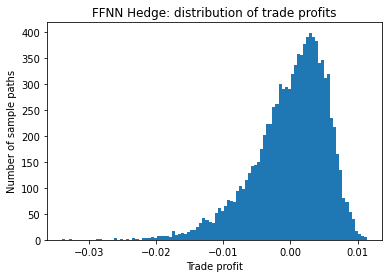

In [14]:
plt.title("FFNN Hedge: distribution of trade profits")
plt.xlabel("Trade profit")
plt.ylabel("Number of sample paths")
plt.hist(path_losses, bins=100);

In [15]:
print(f"Mean trade profit across test set: {np.mean(path_losses)}")

Mean trade profit across test set: 1.5992343116377316e-05


### Observation

The FFNN works identically even if we don't scale the data down, whereas the RNN does not train unless we scale the data. 